Load data

In [275]:
import pandas as pd

In [276]:
data = pd.read_csv('application_train.csv')
data.sample()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
280508,424980,0,Cash loans,F,N,N,0,225000.0,2156400.0,59431.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
data.shape

(307511, 122)

It's a little painful to type (and read) the column names in UPPER CASE.  Let's make them lowercase. 

In [278]:
df = data.copy()
df = df.rename(columns=lambda x: x.lower())
df.sample()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
233853,370879,0,Cash loans,M,N,Y,1,369000.0,629325.0,26793.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We know apriori that there are null values in the entries.  Let us just find out which coulms contain any null value. 

In [279]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

67

We have to impute the missing (null) values.  However, the imputation strategy may be different based on the datatype.  Let's find which missing columns are numerical and which are categorical. 

In [280]:
has_null_num = [col for col in has_null 
                if df[col].dtype == 'float']

len(has_null_num)

61

In [281]:
has_null_cat = [col for col in has_null 
                if df[col].dtype == 'object']

len(has_null_cat)

6

Looks like `61` missing-value columns are numerical and `6` missing-value columns are categorical.  For simplicity we shall replace the missing values of a numerical column by the mean of that column.  We shall address the categorical columns individually.  Before we move on though, we whould be wary of missing values in the target column.  Let's see if there are any.  

In [282]:
'target' in has_null

False

In [283]:
df['target'].value_counts()

0    282686
1     24825
Name: target, dtype: int64

Now fill in the missing values with means.  

In [284]:
for col in has_null_num:
    df[col].fillna(df[col].mean(), inplace=True)

Let's check if we have any more null values.  

In [285]:
has_null_num = [col for col in df.columns 
                if (sum(df[col].isnull()) 
                    and df[col].dtype == 'float')]

len(has_null_num)

0

In [286]:
has_null_cat

['name_type_suite',
 'occupation_type',
 'fondkapremont_mode',
 'housetype_mode',
 'wallsmaterial_mode',
 'emergencystate_mode']

In [287]:
df[has_null_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
name_type_suite        306219 non-null object
occupation_type        211120 non-null object
fondkapremont_mode     97216 non-null object
housetype_mode         153214 non-null object
wallsmaterial_mode     151170 non-null object
emergencystate_mode    161756 non-null object
dtypes: object(6)
memory usage: 14.1+ MB


In [288]:
for col in has_null_cat:
    df[col].fillna('unknown_col', inplace=True)

Let's see if there is any null entry any more.  

In [289]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

0

Awesome!  Let's move onto modeling.  

In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [291]:
vectorizer = TfidfVectorizer() 

In [292]:
col_cat = [col for col in df.columns 
          
           if df[col].dtype == 'object']

In [293]:
len(col_cat)

16

In [294]:
col_num_con = [col for col in df.columns
          if df[col].dtype == 'float']

len(col_num_con)

65

In [295]:
col_num_dis = [col for col in df.columns
              if df[col].dtype == 'int']

len(col_num_dis)

41

In [296]:
col_cat

['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'fondkapremont_mode',
 'housetype_mode',
 'wallsmaterial_mode',
 'emergencystate_mode']

In [297]:
def join_words(text):
    return '_'.join(text.strip().split(" "))

In [298]:
join_words(' car mechanic')

'car_mechanic'

In [299]:
for col in col_cat:
    df[col] = [val+'_'+col for val in df[col]]
    df[col] = df[col].apply(join_words)

In [300]:
df[col_cat[2]].sample()

161388    Y_flag_own_car
Name: flag_own_car, dtype: object

In [303]:
X = df.copy()
X.sample()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
137520,259497,0,Cash_loans_name_contract_type,F_code_gender,N_flag_own_car,Y_flag_own_realty,0,144000.0,263686.5,26208.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,8.0


In [305]:
X.drop(col_cat, axis=1, inplace=True)
X.shape

(307511, 106)

In [308]:
for col in col_cat:
    Xvec = vectorizer.fit_transform(df[col])
    Xvec = pd.DataFrame(
        Xvec.toarray(), 
        columns=vectorizer.get_feature_names())
    
    X = X.join(Xvec)
    

In [311]:
X.sample()

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,...,mixed_wallsmaterial_mode,monolithic_wallsmaterial_mode,others_wallsmaterial_mode,panel_wallsmaterial_mode,stone,unknown_col_wallsmaterial_mode,wooden_wallsmaterial_mode,no_emergencystate_mode,unknown_col_emergencystate_mode,yes_emergencystate_mode
233107,370001,0,0,90000.0,395766.0,20335.5,283500.0,0.020713,-10399,-2557,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [50]:
from sklearn.model_selection import train_test_split

In [312]:
y = X['target']
X = X.drop('target', axis=1)

In [313]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

The data is definitely high dimensional and hence expected to be sparse.  We could start with Naive Bayes.   

### Naive Bayes

In [314]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)

In [315]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.9126928380030698

More than 90%!  That's fabulous!  Is this true?  Let's see the confusion matrix. 

In [316]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)

In [317]:
con_mat

array([[70123,   601],
       [ 6111,    43]])

In [318]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

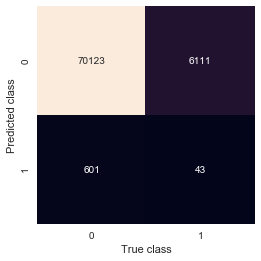

In [319]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [320]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.49924475139775826

### Logistic regression

In [321]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
ypred = lr.predict(Xtest)

In [322]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.9199510913395249

More than 90%!  That's fabulous!  Is this true?  Let's see the confusion matrix. 

In [323]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[70724,     0],
       [ 6154,     0]])

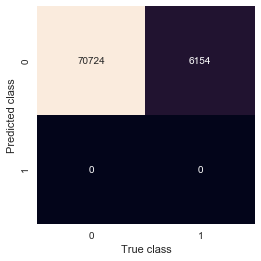

In [324]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [325]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5

### Random Forest

In [326]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

In [327]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.9193137178386535

More than 90%!  That's fabulous!  Is this true?  Let's see the confusion matrix. 

In [328]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[70620,   104],
       [ 6099,    55]])

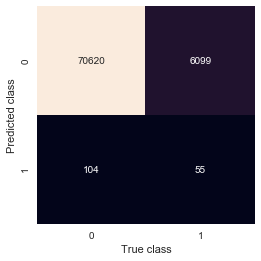

In [329]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

In [330]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5037333857530775

Okay things are BAD!  